# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']
x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 1

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

Date (mm.dd.yyyy) Time 24hr  Temp C  Sp Cond (uS/cm)  pH (mV)    pH  \
0          5/5/2017      0:00   15.02             1848   -100.1  8.36   
1          5/5/2017      0:15   14.99             1847   -100.1  8.36   
2          5/5/2017      0:30   14.96             1847   -100.1  8.36   
3          5/5/2017      0:45   14.95             1848   -100.1  8.36   
4          5/5/2017      1:00   14.92             1848   -100.0  8.36   

   Turbidity (NTU)  ODOSat%  ODO (mg/L)  BGA-Phycocyanin RFU  
0            16.84     90.2        9.04                  0.4  
1            16.76     90.2        9.04                  0.4  
2            16.82     90.1        9.04                  0.4  
3            17.19     90.0        9.03                  0.4  
4            16.85     89.8        9.02                  0.4

In [4]:
test_dfs[test_index].head()

Time America/Boise UTC-06:00  Temp C  Sp Cond (uS/cm)  pH (mV)    pH  \
0              4/11/2018 11:15   11.06             1874   -114.2  8.39   
1              4/11/2018 11:30   10.98             1879   -114.2  8.39   
2              4/11/2018 11:45   10.58             1865   -113.8  8.39   
3              4/11/2018 12:00   10.67             1864   -114.1  8.39   
4              4/11/2018 12:15   10.71             1864   -114.3  8.40   

   Turbidity (NTU)  ODOSat%  ODO (mg/L)  BGA-Phycocyanin RFU  
0            46.27     89.3        9.78                  0.7  
1            46.55     89.2        9.78                  0.8  
2            48.62     87.5        9.68                  0.9  
3            47.96     88.0        9.72                  0.8  
4            49.47     88.3        9.75                  0.8

In [5]:
train_dfs[train_index].describe()

Temp C  Sp Cond (uS/cm)       pH (mV)            pH  \
count  18947.000000     18947.000000  18947.000000  18947.000000   
mean      18.488235      1933.564575   -116.806951      8.633415   
std        6.134464       151.800551      8.973830      0.147231   
min        5.630000         3.000000   -153.700000      7.930000   
25%       12.700000      1848.000000   -120.800000      8.530000   
50%       20.320000      1939.000000   -115.700000      8.650000   
75%       23.630000      2070.000000   -112.100000      8.700000   
max       28.570000      2164.000000    -76.500000      9.230000   

       Turbidity (NTU)       ODOSat%    ODO (mg/L)  BGA-Phycocyanin RFU  
count     18947.000000  18947.000000  18947.000000         18947.000000  
mean         58.129348     87.056980      8.179008             0.979511  
std          54.622278     13.793755      1.278416             0.731423  
min           0.660000     62.800000      5.170000             0.000000  
25%          29.850000     80.000000      7.260000             0.500000  
50%          42.140000     83.200000      8.080000             0.900000  
75%          65.795000     88.900000      9.250000             1.200000  
max         636.700000    209.700000     16.170000            16.100000

In [6]:
test_dfs[test_index].describe()

Temp C  Sp Cond (uS/cm)       pH (mV)            pH  \
count  19484.000000     19484.000000  19484.000000  19484.000000   
mean      18.811541      2105.587354   -136.048199      8.752403   
std        5.116165       168.535267     12.108105      0.207511   
min        7.550000         2.000000   -176.400000      8.390000   
25%       15.260000      1961.000000   -145.800000      8.600000   
50%       19.910000      2145.000000   -131.700000      8.690000   
75%       22.750000      2237.000000   -127.600000      8.930000   
max       28.220000      2389.000000   -113.800000      9.450000   

       Turbidity (NTU)       ODOSat%    ODO (mg/L)  BGA-Phycocyanin RFU  
count     19484.000000  19484.000000  19484.000000         19484.000000  
mean         69.619871     87.104491      8.094141             1.681426  
std          66.298007     13.022364      1.136476             1.547929  
min           0.000000     62.800000      5.140000            -0.400000  
25%          37.500000     79.400000      7.300000             0.700000  
50%          52.935000     83.400000      7.880000             1.200000  
75%          79.022500     91.200000      8.770000             2.100000  
max        2273.070000    191.300000     15.340000            28.300000

## Use Datetime Index

In [7]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [8]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

Temp C  Sp Cond (uS/cm)  pH (mV)    pH  Turbidity (NTU)  \
timestamp                                                                      
2017-05-05 00:00:00   15.02             1848   -100.1  8.36            16.84   
2017-05-05 00:15:00   14.99             1847   -100.1  8.36            16.76   
2017-05-05 00:30:00   14.96             1847   -100.1  8.36            16.82   
2017-05-05 00:45:00   14.95             1848   -100.1  8.36            17.19   
2017-05-05 01:00:00   14.92             1848   -100.0  8.36            16.85   

                     ODOSat%  ODO (mg/L)  BGA-Phycocyanin RFU  \
timestamp                                                       
2017-05-05 00:00:00     90.2        9.04                  0.4   
2017-05-05 00:15:00     90.2        9.04                  0.4   
2017-05-05 00:30:00     90.1        9.04                  0.4   
2017-05-05 00:45:00     90.0        9.03                  0.4   
2017-05-05 01:00:00     89.8        9.02                  0.4   

                               datetime  
timestamp                                
2017-05-05 00:00:00 2017-05-05 00:00:00  
2017-05-05 00:15:00 2017-05-05 00:15:00  
2017-05-05 00:30:00 2017-05-05 00:30:00  
2017-05-05 00:45:00 2017-05-05 00:45:00  
2017-05-05 01:00:00 2017-05-05 01:00:00

In [9]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

Temp C  Sp Cond (uS/cm)  pH (mV)    pH  Turbidity (NTU)  \
timestamp                                                                      
2018-04-11 11:15:00   11.06             1874   -114.2  8.39            46.27   
2018-04-11 11:30:00   10.98             1879   -114.2  8.39            46.55   
2018-04-11 11:45:00   10.58             1865   -113.8  8.39            48.62   
2018-04-11 12:00:00   10.67             1864   -114.1  8.39            47.96   
2018-04-11 12:15:00   10.71             1864   -114.3  8.40            49.47   

                     ODOSat%  ODO (mg/L)  BGA-Phycocyanin RFU  \
timestamp                                                       
2018-04-11 11:15:00     89.3        9.78                  0.7   
2018-04-11 11:30:00     89.2        9.78                  0.8   
2018-04-11 11:45:00     87.5        9.68                  0.9   
2018-04-11 12:00:00     88.0        9.72                  0.8   
2018-04-11 12:15:00     88.3        9.75                  0.8   

                               datetime  
timestamp                                
2018-04-11 11:15:00 2018-04-11 11:15:00  
2018-04-11 11:30:00 2018-04-11 11:30:00  
2018-04-11 11:45:00 2018-04-11 11:45:00  
2018-04-11 12:00:00 2018-04-11 12:00:00  
2018-04-11 12:15:00 2018-04-11 12:15:00

## Import And Clean Weather Data

In [10]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

STATION              NAME  LATITUDE  LONGITUDE  ELEVATION      DATE  \
0  USC00427064  PROVO BYU, UT US   40.2458  -111.6508     1392.9  5/1/2017   
1  USC00427064  PROVO BYU, UT US   40.2458  -111.6508     1392.9  5/2/2017   
2  USC00427064  PROVO BYU, UT US   40.2458  -111.6508     1392.9  5/3/2017   
3  USC00427064  PROVO BYU, UT US   40.2458  -111.6508     1392.9  5/4/2017   
4  USC00427064  PROVO BYU, UT US   40.2458  -111.6508     1392.9  5/5/2017   

   DAPR  EVAP  MDPR  MNPN  ...   TMAX  TMIN  TOBS  WESD  WESF  WT01  WT03  \
0   NaN   NaN   NaN   NaN  ...   18.9   7.2  13.3   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN  ...   19.4   7.8  17.8   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN  ...   21.7   4.4  21.1   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN  ...   26.7   6.7  26.7   NaN   NaN   NaN   NaN   
4   NaN   NaN   NaN   NaN  ...   31.7   8.9  30.6   NaN   NaN   NaN   NaN   

   WT04  WT05  WT11  
0   NaN   NaN   NaN  
1   NaN   NaN   NaN  
2   NaN   NaN   NaN  
3   NaN   NaN   NaN  
4   NaN   NaN   NaN  

[5 rows x 25 columns]

In [11]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [12]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [13]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [14]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [15]:
# Test some date comparison logic
print(train_dfs[train_index]['datetime'][0].date())
print(weather['DATE'][0])
print(train_dfs[train_index]['datetime'][0].date() == weather['DATE'][0])
print()
print(train_dfs[train_index]['datetime'][0].date())
print(weather['DATE'][4])
print(train_dfs[train_index]['datetime'][0].date() == weather['DATE'][4])


2017-05-05
2017-05-01
False

2017-05-05
2017-05-05
True


In [16]:
# Test some indexing logic
weather[weather['DATE'] == train_dfs[train_index]['datetime'][2].date()]['PRCP'].values[0]

0.0

In [17]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Verify weather values copied over correctly

In [18]:
train_dfs[train_index].head(10)

Temp C  Sp Cond (uS/cm)  pH (mV)    pH  Turbidity (NTU)  \
timestamp                                                                      
2017-05-05 00:00:00   15.02             1848   -100.1  8.36            16.84   
2017-05-05 00:15:00   14.99             1847   -100.1  8.36            16.76   
2017-05-05 00:30:00   14.96             1847   -100.1  8.36            16.82   
2017-05-05 00:45:00   14.95             1848   -100.1  8.36            17.19   
2017-05-05 01:00:00   14.92             1848   -100.0  8.36            16.85   
2017-05-05 01:15:00   14.92             1850   -100.1  8.36            16.43   
2017-05-05 01:30:00   14.90             1851   -100.1  8.36            16.35   
2017-05-05 01:45:00   14.88             1852   -100.0  8.36            16.40   
2017-05-05 02:00:00   14.84             1850    -99.9  8.36            16.82   
2017-05-05 02:15:00   14.83             1851   -100.0  8.36            16.50   

                     ODOSat%  ODO (mg/L)  BGA-Phycocyanin RFU  \
timestamp                                                       
2017-05-05 00:00:00     90.2        9.04                  0.4   
2017-05-05 00:15:00     90.2        9.04                  0.4   
2017-05-05 00:30:00     90.1        9.04                  0.4   
2017-05-05 00:45:00     90.0        9.03                  0.4   
2017-05-05 01:00:00     89.8        9.02                  0.4   
2017-05-05 01:15:00     89.8        9.02                  0.4   
2017-05-05 01:30:00     89.7        9.01                  0.4   
2017-05-05 01:45:00     89.6        9.00                  0.4   
2017-05-05 02:00:00     89.4        8.99                  0.4   
2017-05-05 02:15:00     89.4        8.99                  0.4   

                               datetime  PRCP  SNOW  SNWD  TMAX  TMIN  
timestamp                                                              
2017-05-05 00:00:00 2017-05-05 00:00:00   0.0   0.0   0.0  31.7   8.9  
2017-05-05 00:15:00 2017-05-05 00:15:00   0.0   0.0   0.0  31.7   8.9  
2017-05-05 00:30:00 2017-05-05 00:30:00   0.0   0.0   0.0  31.7   8.9  
2017-05-05 00:45:00 2017-05-05 00:45:00   0.0   0.0   0.0  31.7   8.9  
2017-05-05 01:00:00 2017-05-05 01:00:00   0.0   0.0   0.0  31.7   8.9  
2017-05-05 01:15:00 2017-05-05 01:15:00   0.0   0.0   0.0  31.7   8.9  
2017-05-05 01:30:00 2017-05-05 01:30:00   0.0   0.0   0.0  31.7   8.9  
2017-05-05 01:45:00 2017-05-05 01:45:00   0.0   0.0   0.0  31.7   8.9  
2017-05-05 02:00:00 2017-05-05 02:00:00   0.0   0.0   0.0  31.7   8.9  
2017-05-05 02:15:00 2017-05-05 02:15:00   0.0   0.0   0.0  31.7   8.9

In [19]:
weather.head(10)

DATE  PRCP  SNOW  SNWD  TMAX  TMIN
timestamp                                           
2017-05-01  2017-05-01   0.0   0.0   0.0  18.9   7.2
2017-05-02  2017-05-02   0.0   0.0   0.0  19.4   7.8
2017-05-03  2017-05-03   0.0   0.0   0.0  21.7   4.4
2017-05-04  2017-05-04   0.0   0.0   0.0  26.7   6.7
2017-05-05  2017-05-05   0.0   0.0   0.0  31.7   8.9
2017-05-06  2017-05-06   1.8   0.0   0.0  30.6  15.0
2017-05-07  2017-05-07   0.0   0.0   0.0  27.2  18.9
2017-05-08  2017-05-08   0.0   0.0   0.0  25.6  12.2
2017-05-09  2017-05-09   0.0   0.0   0.0  25.6   9.4
2017-05-10  2017-05-10   0.0   0.0   0.0  25.0  10.6

In [20]:
test_dfs[test_index].head(60)

Temp C  Sp Cond (uS/cm)  pH (mV)    pH  Turbidity (NTU)  \
timestamp                                                                      
2018-04-11 11:15:00   11.06             1874   -114.2  8.39            46.27   
2018-04-11 11:30:00   10.98             1879   -114.2  8.39            46.55   
2018-04-11 11:45:00   10.58             1865   -113.8  8.39            48.62   
2018-04-11 12:00:00   10.67             1864   -114.1  8.39            47.96   
2018-04-11 12:15:00   10.71             1864   -114.3  8.40            49.47   
2018-04-11 12:30:00   10.75             1861   -114.4  8.40            47.66   
2018-04-11 12:45:00   10.66             1865   -114.3  8.40            48.23   
2018-04-11 13:00:00   10.82             1886   -114.8  8.41            47.22   
2018-04-11 13:15:00   10.84             1915   -114.4  8.40            50.80   
2018-04-11 13:30:00   11.03             1912   -114.9  8.41            50.35   
2018-04-11 13:45:00   10.96             1919   -115.0  8.41            50.01   
2018-04-11 14:00:00   10.99             1920   -115.2  8.41            50.64   
2018-04-11 14:15:00   11.00             1919   -115.3  8.42            46.94   
2018-04-11 14:30:00   10.82             1921   -115.0  8.41            50.75   
2018-04-11 14:45:00   10.83             1920   -114.8  8.41            50.49   
2018-04-11 15:00:00   10.84             1920   -114.9  8.41            50.75   
2018-04-11 15:15:00   10.89             1920   -114.9  8.41            50.89   
2018-04-11 15:30:00   11.01             1919   -115.1  8.41            50.43   
2018-04-11 15:45:00   11.85             1906   -116.0  8.42            49.47   
2018-04-11 16:00:00   12.33             1905   -116.2  8.42            48.43   
2018-04-11 16:15:00   12.46             1911   -116.6  8.43            47.45   
2018-04-11 16:30:00   12.36             1909   -116.6  8.43            46.70   
2018-04-11 16:45:00   12.53             1908   -116.6  8.43            47.41   
2018-04-11 17:00:00   12.34             1906   -116.5  8.43            47.91   
2018-04-11 17:15:00   12.33             1908   -116.3  8.43            47.15   
2018-04-11 17:30:00   12.38             1913   -116.3  8.43            47.01   
2018-04-11 17:45:00   11.80             1914   -115.4  8.41            47.08   
2018-04-11 18:00:00   11.74             1916   -115.2  8.41            47.71   
2018-04-11 18:15:00   11.46             1917   -114.7  8.40            49.86   
2018-04-11 18:30:00   11.37             1918   -114.5  8.40            51.28   
2018-04-11 18:45:00   11.34             1918   -114.3  8.39            54.64   
2018-04-11 19:00:00   11.33             1918   -114.4  8.40            56.64   
2018-04-11 19:15:00   11.32             1918   -114.5  8.40            57.69   
2018-04-11 19:30:00   11.32             1918   -114.5  8.40            62.37   
2018-04-11 19:45:00   11.33             1918   -114.6  8.40            63.71   
2018-04-11 20:00:00   11.33             1918   -114.5  8.40            65.84   
2018-04-11 20:15:00   11.32             1918   -114.6  8.40            66.21   
2018-04-11 20:30:00   11.31             1918   -114.6  8.40            66.50   
2018-04-11 20:45:00   11.30             1918   -114.7  8.40            67.36   
2018-04-11 21:00:00   11.28             1917   -114.7  8.40            68.19   
2018-04-11 21:15:00   11.27             1916   -114.8  8.40            68.92   
2018-04-11 21:30:00   11.23             1916   -114.8  8.40            68.33   
2018-04-11 21:45:00   11.20             1916   -114.8  8.40            68.13   
2018-04-11 22:00:00   11.15             1916   -114.8  8.40            67.77   
2018-04-11 22:15:00   11.13             1916   -114.8  8.40            68.17   
2018-04-11 22:30:00   11.12             1916   -114.7  8.40            69.02   
2018-04-11 22:45:00   11.13             1917   -114.7  8.40            70.58   
2018-04-11 23:00:00   11.14             1918   -114.6  8.40            70.64   
2018-04-11 23:15:00  

In [21]:
start = test_dfs[test_index]['datetime'][0].date()
end = test_dfs[test_index]['datetime'][60].date()
weather[start:end]

DATE  PRCP  SNOW  SNWD  TMAX  TMIN
timestamp                                           
2018-04-11  2018-04-11   0.0   0.0   0.0  25.0  10.0
2018-04-12  2018-04-12   1.8   0.0   0.0  21.7   3.3

## Weather Investigation

In [22]:
df = train_dfs[train_index].drop(columns=['datetime'])
df.describe()

Temp C  Sp Cond (uS/cm)       pH (mV)            pH  \
count  18947.000000     18947.000000  18947.000000  18947.000000   
mean      18.488235      1933.564575   -116.806951      8.633415   
std        6.134464       151.800551      8.973830      0.147231   
min        5.630000         3.000000   -153.700000      7.930000   
25%       12.700000      1848.000000   -120.800000      8.530000   
50%       20.320000      1939.000000   -115.700000      8.650000   
75%       23.630000      2070.000000   -112.100000      8.700000   
max       28.570000      2164.000000    -76.500000      9.230000   

       Turbidity (NTU)       ODOSat%    ODO (mg/L)  BGA-Phycocyanin RFU  \
count     18947.000000  18947.000000  18947.000000         18947.000000   
mean         58.129348     87.056980      8.179008             0.979511   
std          54.622278     13.793755      1.278416             0.731423   
min           0.660000     62.800000      5.170000             0.000000   
25%          29.850000     80.000000      7.260000             0.500000   
50%          42.140000     83.200000      8.080000             0.900000   
75%          65.795000     88.900000      9.250000             1.200000   
max         636.700000    209.700000     16.170000            16.100000   

               PRCP     SNOW     SNWD          TMAX          TMIN  
count  18947.000000  18947.0  18947.0  18947.000000  18947.000000  
mean       0.527450      0.0      0.0     27.982852     11.708170  
std        2.446299      0.0      0.0      8.039940      6.272027  
min        0.000000      0.0      0.0      6.100000     -3.900000  
25%        0.000000      0.0      0.0     21.100000      6.100000  
50%        0.000000      0.0      0.0     30.600000     13.300000  
75%        0.000000      0.0      0.0     35.000000     17.200000  
max       23.400000      0.0      0.0     40.000000     22.200000

In [23]:
#Scale the date for easy chart comparisons
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df)

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


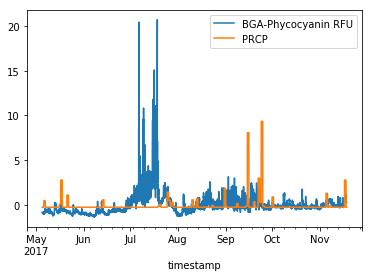

In [24]:
df[[target_column, 'PRCP']].plot.line()

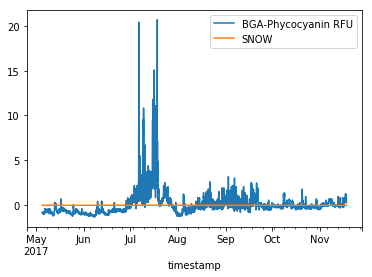

In [25]:
df[[target_column, 'SNOW']].plot.line()

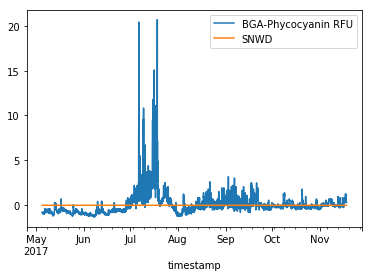

In [26]:
df[[target_column, 'SNWD']].plot.line()

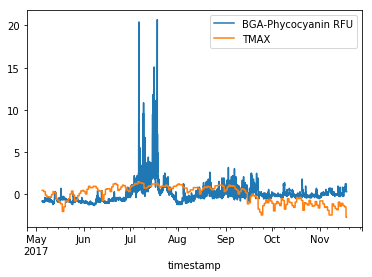

In [27]:
df[[target_column, 'TMAX']].plot.line()

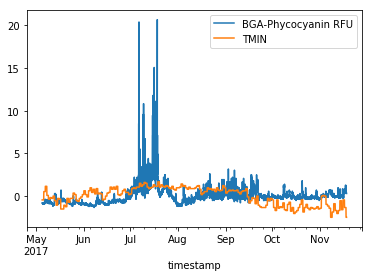

In [28]:
df[[target_column, 'TMIN']].plot.line()

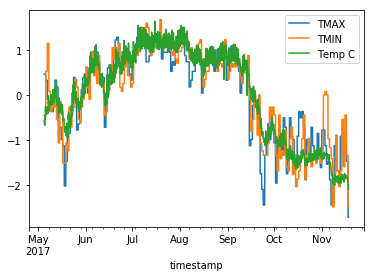

In [29]:
df[['TMAX', 'TMIN', 'Temp C']].plot.line()

As expected, we won't get any additional signal from air temperature measurements since they correlate to water temperature. And since the area has so little rain, rain will most likely not provide a decent signal either

## Extract Windows

In [30]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

In [31]:
def windowize(df, time_column):
    print("Segmenting...")
    x_windows, y_windows = hf.segment_dataset(df, time_column)
    print("Extracting feature windows...")
    x_windows = hf.extract_percentile(x_windows, time_column)
    print("Extracting target windows...")
    y_windows = hf.extract_percentile(y_windows, time_column)
    print("Combining extractions...")
    x_windows[target_column] = y_windows[target_column].values
    return x_windows

In [32]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = windowize(train_dfs[i], 'datetime')
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = windowize(test_dfs[i], 'datetime')
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



## Add Weather Category

In [33]:
# Add a rainy category
for df in test_dfs + train_dfs:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')
test_dfs[test_index].columns

Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'PRCP', 'SNOW', 'SNWD',
       'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)',
       'datetime', 'pH', 'pH (mV)', 'rainy'],
      dtype='object')

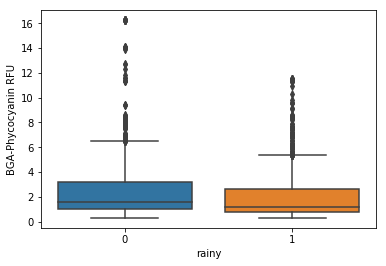

In [34]:
sns.boxplot(data=test_dfs[test_index], x='rainy', y=target_column)

In [35]:
# add the weather columns to our x_columns
x_columns = x_columns + ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'rainy']

## BGA RFU Levels

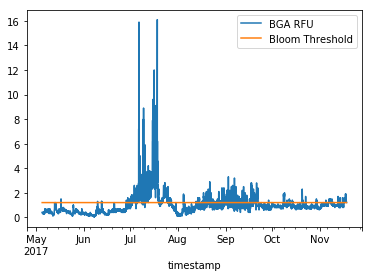

In [36]:
presegmented_plot.plot.line()

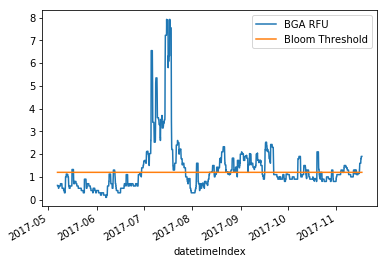

In [37]:
pd.DataFrame({'BGA RFU': train_dfs[train_index][target_column], 
            'Bloom Threshold': np.full(
                train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

In [45]:

lrf.add_target_column([train_dfs, test_dfs], threshold=RFU_THRESHOLD)
#lrf.add_target_column(test_dfs, threshold=RFU_THRESHOLD)

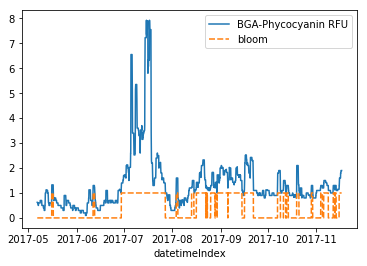

In [39]:
sns.lineplot(data=train_dfs[train_index][[target_column, 'bloom']], hue='bloom')

## Logistic Regression Model

### Null Model

In [40]:
# The null model's performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train_dfs[train_index].columns)

Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'PRCP', 'SNOW', 'SNWD',
       'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)',
       'datetime', 'pH', 'pH (mV)', 'rainy', 'bloom'],
      dtype='object')


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### All variables model

In [41]:
# All variables model performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", x_columns)

Accuracy 0.7626588872681809
Recall: 0.933959101575595
Precision 0.7473175965665236
Confusion Matrix:
 [[ 874  942]
 [ 197 2786]]
columns: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'rainy']


### Greedy Model

In [42]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: Temp C
Accuracy 0.6072098353823713
Recall: 0.39088166275561514
Precision 0.9448946515397083
Confusion Matrix:
 [[1748   68]
 [1817 1166]]

Training model with: Sp Cond (uS/cm)


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: pH (mV)
Accuracy 0.6228380912690143
Recall: 0.9963124371438149
Precision 0.6229302033116747
Confusion Matrix:
 [[  17 1799]
 [  11 2972]]

Training model with: pH
Accuracy 0.7589081058553865
Recall: 0.6895742541066041
Precision 0.8990384615384616
Confusion Matrix:
 [[1585  231]
 [ 926 2057]]

Training model with: Turbidity (NTU)


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: ODOSat%
Accuracy 0.6799333194415503
Recall: 0.5095541401273885
Precision 0.9541745134965474
Confusion Matrix:
 [[1743   73]
 [1463 1520]]

Training model with: ODO (mg/L)
Accuracy 0.5788705980412586
Recall: 0.36808581964465303
Precision 0.8897893030794165
Confusion Matrix:
 [[1680  136]
 [1885 1098]]

Training model with: PRCP


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: SNOW


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: SNWD


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

Training model with: TMAX
Accuracy 0.5865805376120025
Recall: 0.45759302715387196
Precision 0.7885615251299827
Confusion Matrix:
 [[1450  366]
 [1618 1365]]

Training model with: TMIN
Accuracy 0.6686809752031673
Recall: 0.5306738183037211
Precision 0.8928369994359842
Confusion Matrix:
 [[1626  190]
 [1400 1583]]

Training model with: rainy
Accuracy 0.37841216920191706
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[1816    0]
 [2983    0]]

pH metric value: 0.7589081058553865
ODOSat% metric value: 0.6799333194415503
TMIN metric value: 0.6686809752031673
pH (mV) metric value: 0.6228380912690143
Temp C metric value: 0.6072098353823713
TMAX metric value: 0.5865805376120025
ODO (mg/L) metric value: 0.5788705980412586
Sp Cond (uS/cm) metric value: 0.37841216920191706
Turbidity (NTU) metric value: 0.37841216920191706
PRCP metric value: 0.37841216920191706
SNOW metric value: 0.3784121692019170

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


greedy_columns: []
sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'SNWD', 'rainy']
adjusted sorted_columns: ['pH', 'ODOSat%', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'ODO (mg/L)', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'SNWD', 'rainy']
Training model with: ['pH']
Test model accuracy: 0.7589081058553865
Test model recall: 0.6895742541066041
Test model precision: 0.8990384615384616

Updating greedy model

Training model with: ['pH', 'ODOSat%']
Test model accuracy: 0.7884976036674307
Test model recall: 0.7006369426751592
Test model precision: 0.9448462929475587

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7797457803709106
Test model recall: 0.6754944686557157
Test model precision: 0.9576996197718631

Training model with: ['pH', 'ODOSat%', 'pH (mV)']
Test model accuracy: 0.8235048968535111
Test model recall: 0.8028830036875628
Test model p

Model AUC: 0.9021


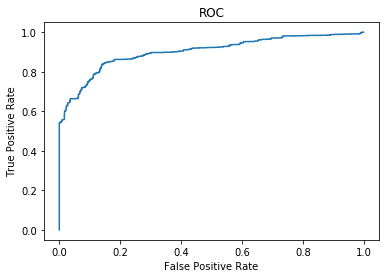

In [44]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

## Cross Validation

In [46]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)

results = lrf.cross_validate(model, train_dfs, test_dfs, x_columns, 'bloom')

In [47]:
for key in results.keys():
    a_r_p = results[key]
    print('Values for {}'.format(key))
    print('Accuracy: {}'.format(a_r_p[0]))
    print('Recall: {}'.format(a_r_p[1]))
    print('Precision: {}\r\n'.format(a_r_p[2]))

Values for dfl0_dfe0
Accuracy: 0.6087888531618435
Recall: 0.9410828025477707
Precision: 0.5084599942644107

Values for dfe0_dfl0
Accuracy: 0.5802957717142262
Recall: 1.0
Precision: 0.5802957717142262

Values for dfl1_dfe0
Accuracy: 0.8242229367631297
Recall: 0.70276008492569
Precision: 0.8358585858585859

Values for dfe0_dfl1
Accuracy: 0.7626588872681809
Recall: 0.933959101575595
Precision: 0.7473175965665236

Values for dfl0_dfe1
Accuracy: 0.5776411657559198
Recall: 0.9152542372881356
Precision: 0.45877910635619884

Values for dfe1_dfl0
Accuracy: 0.6548635700895646
Recall: 0.9206748025843503
Precision: 0.641089727568108

Values for dfl1_dfe1
Accuracy: 0.837431693989071
Recall: 0.7501569365976145
Precision: 0.7908669755129054

Values for dfe1_dfl1
Accuracy: 0.7568243384038341
Recall: 0.7452229299363057
Precision: 0.8452471482889734



The above results have been tested multiple times and each time the training on the later (test_dfs[test_index]) testing on the earlier (train_dfs[train_index]) resulted in better accuracy but lower recall. 

## Random Forest Model

In [47]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.6871485107269318
Recall: 0.9461593682699211
Precision 0.6609829488465396
Confusion Matrix:
 [[ 663 1352]
 [ 150 2636]]


In [48]:
# Greedy Model
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', sorted_columns)

greedy_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'SNWD', 'rainy']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'SNWD', 'rainy']
Training model with: ['ODOSat%']


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.6698604457404708
Test model recall: 0.6927494615936827
Test model precision: 0.7258367807446409

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.6933972089148094
Test model recall: 0.7796123474515434
Test model precision: 0.7168316831683168

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.664236617371381
Test model recall: 0.6834170854271356
Test model precision: 0.7228549734244495

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.6827744219954176
Test model recall: 0.7476669059583633
Test model precision: 0.7175335859455736

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 0.686940220787336
Test model recall: 0.7631012203876526
Test model precision: 0.7160660154934322

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH (mV)']
Test model accuracy: 0.5696729847948344
Test model recall: 0.9798994974874372
Test mod

Model AUC: 0.7480


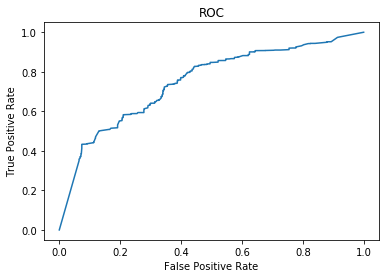

In [49]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)